# Spaceship-Titanic Problem

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import torch
from torch import nn
import torch.nn.functional as F
%matplotlib inline

In [2]:
df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test.csv')
df_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [147]:
df_test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


## Exploration

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


<AxesSubplot:xlabel='Transported', ylabel='Age'>

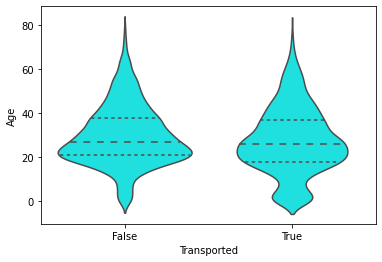

In [4]:
sb.violinplot(data = df_train, x = 'Transported', y ='Age', inner = 'quartile',color = 'cyan' )

<AxesSubplot:xlabel='Transported', ylabel='HomePlanet'>

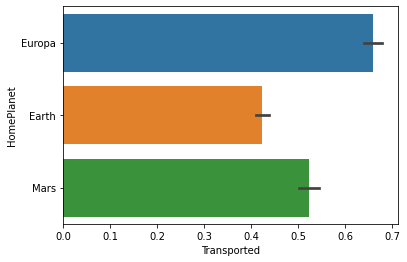

In [5]:
sb.barplot(data=df_train, x='Transported', y='HomePlanet')

In [6]:
Cabins = (df_train.groupby('Transported')['Cabin'].value_counts().unstack().fillna(0))
Cabins.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2 entries, False to True
Columns: 6560 entries, A/0/P to T/3/P
dtypes: float64(6560)
memory usage: 102.5+ KB


<AxesSubplot:title={'center':'VIP vs Transported'}, xlabel='Transported', ylabel='VIP'>

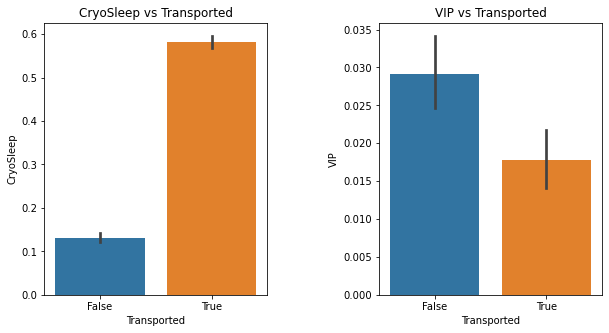

In [7]:
plt.figure(figsize=[10, 5])
plt.subplots_adjust(wspace=0.5,hspace=0.5)
plt.subplot(1, 2, 1)
plt.title('CryoSleep vs Transported')
sb.barplot(data=df_train, x='Transported', y='CryoSleep')
plt.subplot(1, 2, 2)
plt.title('VIP vs Transported')
sb.barplot(data=df_train, x='Transported', y='VIP')

<AxesSubplot:xlabel='Transported', ylabel='Destination'>

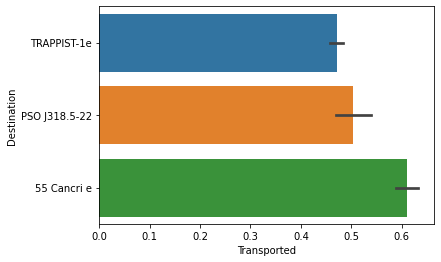

In [8]:
sb.barplot(data=df_train, x='Transported', y='Destination')

In [9]:
df_train['luxury'] = df_train['RoomService']+df_train['FoodCourt']+df_train['ShoppingMall']+df_train['Spa']+df_train['VRDeck']
df_train['luxury']

0           0.0
1         736.0
2       10383.0
3        5176.0
4        1091.0
         ...   
8688     8536.0
8689        0.0
8690     1873.0
8691     4637.0
8692     4826.0
Name: luxury, Length: 8693, dtype: float64

In [10]:
lux_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'luxury']

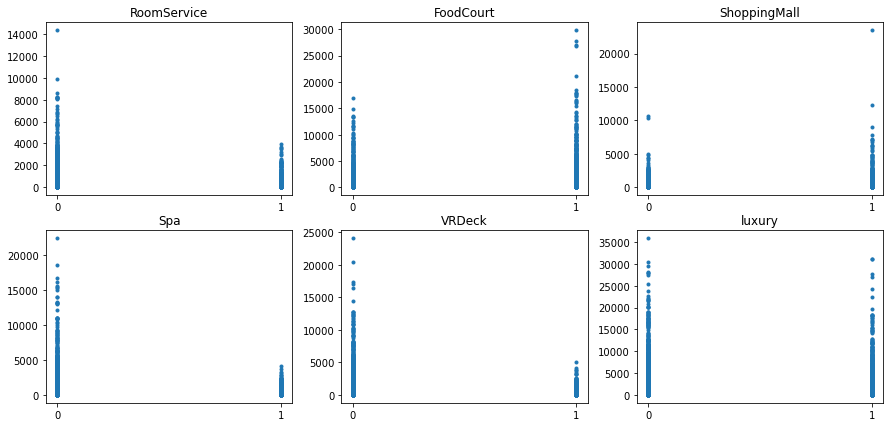

In [11]:
plt.figure(figsize=[15, 7])
i = 1
for col in lux_columns:
    plt.subplot(2, 3, i)
    plt.title(col)
    plt.plot(df_train['Transported'], df_train[col], '.')
    plt.xticks([0,1]);
    i+=1


In [12]:
df_train.drop('luxury', axis=1, inplace=True)

## Data Preparation

In [13]:
df_copy = df_train.copy()

In [14]:
def transform_data(df_copy):
    
    drop = ['PassengerId',  'Name','Cabin']
    for d in drop:
        df_copy.drop(d, axis=1, inplace=True)
        
    binary_columns = ['CryoSleep', 'VIP', 'Transported']
    for col in binary_columns:
        df_copy[col] = df_copy[col].map({True: 1, False: 0})
        most_freq = df_copy[col].value_counts().idxmax()
        df_copy[col].fillna(value=most_freq, inplace=True)
        
    object_columns = ['HomePlanet', 'Destination']
    for col in object_columns:
        freq_obj = df_copy['VIP'].value_counts().idxmax()
        df_copy[col].fillna(value=freq_obj, inplace=True)
        
    numeric_columns = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    for col in numeric_columns:
        mean_value = df_copy[col].mean()
        df_copy[col].fillna(value=mean_value, inplace=True)
        
    for col in numeric_columns:
        df_copy[col] = (df_copy[col] - min(df_copy[col]))/(max(df_copy[col])-min(df_copy[col]))
        
    labels = df_copy['Transported']
    labels = labels.map({True: 1, False: 0})
    df_copy.drop('Transported', axis=1, inplace=True)
    
    for col in object_columns:
        df_copy = pd.concat([df_copy, pd.get_dummies(df_copy[col], prefix = col)], axis=1)
        df_copy.drop(col, axis=1, inplace=True)
    
    return df_copy, labels

In [15]:
df_copy, labels = transform_data(df_copy)

In [16]:
df_copy.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_0.0,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_0.0,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
0,0.0,0.493671,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,1,0,0,0,0,1
1,0.0,0.303797,0.0,0.007608,0.000302,0.001064,0.024500,0.001823,0,1,0,0,0,0,0,1
2,0.0,0.734177,1.0,0.003001,0.119948,0.000000,0.299670,0.002030,0,0,1,0,0,0,0,1
3,0.0,0.417722,0.0,0.000000,0.043035,0.015793,0.148563,0.007997,0,0,1,0,0,0,0,1
4,0.0,0.202532,0.0,0.021149,0.002348,0.006428,0.025214,0.000083,0,1,0,0,0,0,0,1


In [17]:
labels

0       0
1       1
2       0
3       0
4       1
       ..
8688    0
8689    0
8690    1
8691    0
8692    1
Name: Transported, Length: 8693, dtype: int64

## Splitting Data into Training and Validation

In [18]:
x = df_copy.iloc[:,:]
y = labels.iloc[:]
xtrain, xvalid, ytrain, yvalid = train_test_split(x,y, test_size=0.2, train_size=0.8, random_state=3, shuffle=True, stratify=y)

## Training

In [19]:
#Accuracy function
def scoring(preds, ytest):
    return 1 - np.mean(np.abs(ytest-preds))

### Using KNN

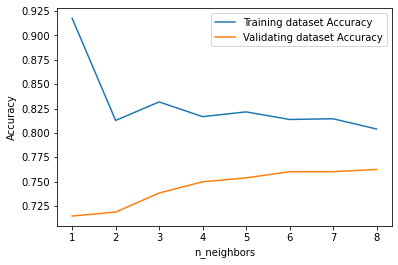

In [20]:
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
valid_accuracy = np.empty(len(neighbors))

for i, k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(xtrain, ytrain)
    
    y_predict_train = knn.predict(xtrain)
    y_predict_valid = knn.predict(xvalid)
    
    train_accuracy[i] = scoring(y_predict_train, ytrain)
    valid_accuracy[i] = scoring(y_predict_valid, yvalid)

plt.plot(neighbors, train_accuracy, label = 'Training dataset Accuracy')
plt.plot(neighbors, valid_accuracy, label = 'Validating dataset Accuracy')

plt.legend()
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.show()

### Using Logistic Regression

In [21]:
logisticRegr = LogisticRegression()
logisticRegr.fit(xtrain, ytrain)

LogisticRegression()

In [22]:
score = logisticRegr.score(xvalid, yvalid)
print(score)

0.7717078780908568


### Using Decision Tree

In [144]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from  sklearn.preprocessing import StandardScaler
cl = Pipeline([("scaler", StandardScaler()), ("svm_clf", SVC(kernel="rbf", gamma=0.001, coef0=1, C=1000))])
cl.fit(xtrain, ytrain)
preds = cl.predict(xvalid)
acc = scoring(preds, yvalid)
acc

0.7947096032202415

Decision Tree will be used for prediction since it gave higher validation accuracy

In [148]:
def transform_tests(df_copy):
    
    drop = ['PassengerId',  'Name','Cabin']
    for d in drop:
        df_copy.drop(d, axis=1, inplace=True)
        
    binary_columns = ['CryoSleep', 'VIP']
    for col in binary_columns:
        df_copy[col] = df_copy[col].map({True: 1, False: 0})
        most_freq = df_copy[col].value_counts().idxmax()
        df_copy[col].fillna(value=most_freq, inplace=True)
        
    object_columns = ['HomePlanet', 'Destination']
    for col in object_columns:
        freq_obj = df_copy['VIP'].value_counts().idxmax()
        df_copy[col].fillna(value=freq_obj, inplace=True)
        
    numeric_columns = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    for col in numeric_columns:
        mean_value = df_copy[col].mean()
        df_copy[col].fillna(value=mean_value, inplace=True)
        
    for col in numeric_columns:
        df_copy[col] = (df_copy[col] - min(df_copy[col]))/(max(df_copy[col])-min(df_copy[col]))
    
    for col in object_columns:
        df_copy = pd.concat([df_copy, pd.get_dummies(df_copy[col], prefix = col)], axis=1)
        df_copy.drop(col, axis=1, inplace=True)
    
    return df_copy

In [149]:
df_test_copy = df_test.copy()
df_test_copy = transform_tests(df_test_copy)
preds = cl.predict(df_test_copy)
preds

array([1, 0, 1, ..., 1, 1, 1], dtype=int64)

In [161]:
prediction = pd.DataFrame(preds, columns=['Transported'])
prediction['PassengerId'] = df_test['PassengerId']
prediction['Transported'] = prediction['Transported'].astype(bool)
columns_titles = ['PassengerId','Transported']
prediction=prediction.reindex(columns=columns_titles)
prediction=prediction.set_index('PassengerId')

In [162]:
prediction.head()

,Transported
PassengerId,
0013_01,True
0018_01,False
0019_01,True
0021_01,True
0023_01,True


In [163]:
prediction.to_csv('prediction.csv')